## **Install & Import Libraries**

In [ ]:
import requests
import gzip
import shutil
import os

# URL dan nama file
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz"
gz_filename = "cc.id.300.vec.gz"
vec_filename = "cc.id.300.vec"

# Fungsi untuk menampilkan progress bar
def download_with_progress(url, filename):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_size = int(r.headers.get('content-length', 0))
        block_size = 8192
        with open(filename, 'wb') as f:
            from tqdm.notebook import tqdm
            with tqdm(total=total_size, unit='iB', unit_scale=True, desc=filename) as pbar:
                for chunk in r.iter_content(chunk_size=block_size):
                    pbar.update(len(chunk))
                    f.write(chunk)
    return total_size

try:
    # Cek apakah file final sudah ada
    if os.path.exists(vec_filename):
        print(f"✅ File '{vec_filename}' sudah ada. Tidak perlu mengunduh lagi.")
    else:
        # --- Langkah 1: Mengunduh file ---
        print(f"📥 Mengunduh file dari {url}...")
        if not os.path.exists(gz_filename):
            download_with_progress(url, gz_filename)
            print(f"✅ File '{gz_filename}' berhasil diunduh.")
        else:
            print(f"File '{gz_filename}' sudah ada. Melewati proses unduh.")

        # --- Langkah 2: Mengekstrak file .gz ---
        print(f"⚙️ Mengekstrak '{gz_filename}'... (Proses ini mungkin memakan waktu beberapa menit)")
        with gzip.open(gz_filename, 'rb') as f_in:
            with open(vec_filename, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"✅ Ekstraksi selesai. File '{vec_filename}' telah dibuat.")

        # --- Langkah 3: Hapus file .gz untuk menghemat ruang ---
        os.remove(gz_filename)
        print(f"🗑️ File '{gz_filename}' telah dihapus untuk menghemat ruang.")

except Exception as e:
    print(f"❌ Terjadi kesalahan: {e}")

📥 Mengunduh file dari https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz...


cc.id.300.vec.gz:   0%|          | 0.00/1.23G [00:00<?, ?iB/s]

✅ File 'cc.id.300.vec.gz' berhasil diunduh.
⚙️ Mengekstrak 'cc.id.300.vec.gz'... (Proses ini mungkin memakan waktu beberapa menit)
✅ Ekstraksi selesai. File 'cc.id.300.vec' telah dibuat.
🗑️ File 'cc.id.300.vec.gz' telah dihapus untuk menghemat ruang.


In [ ]:
!pip install numpy pandas scikit-learn nltk matplotlib seaborn
!pip install tensorflow==2.19.0

In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 12.2 MB/s eta 0:00:00


In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf # Import tensorflow with alias tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional, BatchNormalization # Import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW # Import RMSprop and AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## **Clone Dan Load Sentiment Dataset**

In [ ]:
import os
import pandas as pd

# Clone repo jika belum ada
if not os.path.exists('Dataset-Sentimen-Analisis-Bahasa-Indonesia'):
    !git clone https://github.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia.git
else:
    print("✅ Repository sudah ada, skip clone.")

# Dataset Pilkada
csv_pilkada = 'Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentiment_pilkada_DKI_2017.csv'
try:
    df1 = pd.read_csv(csv_pilkada, encoding='utf-8')
except:
    df1 = pd.read_csv(csv_pilkada, encoding='latin1')

df1 = df1.dropna(subset=['Text Tweet', 'Sentiment'])
df1['Sentiment'] = df1['Sentiment'].str.lower().str.strip()
df1 = df1[['Sentiment', 'Text Tweet']]  # Ambil kolom yang diperlukan

# Dataset Cellular Service Provider
csv_cellular = 'Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentiment_cellular_service_provider.csv'
try:
    df2 = pd.read_csv(csv_cellular, encoding='utf-8')
except:
    df2 = pd.read_csv(csv_cellular, encoding='latin1')

df2 = df2.dropna(subset=['Text Tweet', 'Sentiment'])
df2['Sentiment'] = df2['Sentiment'].str.lower().str.strip()
df2 = df2[['Sentiment', 'Text Tweet']]  # Ambil kolom yang diperlukan

# Gabungkan kedua dataset
df_all = pd.concat([df1, df2], ignore_index=True)

print(f"✅ Dataset gabungan: {df_all.shape[0]} baris")
print(df_all['Sentiment'].value_counts())
print("\n🔎 Sample:")
print(df_all.head(3))


Cloning into 'Dataset-Sentimen-Analisis-Bahasa-Indonesia'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 169 (delta 24), reused 0 (delta 0), pack-reused 123 (from 1)
Receiving objects: 100% (169/169), 164.89 KiB | 16.49 MiB/s, done.
Resolving deltas: 100% (80/80), done.
✅ Dataset gabungan: 1200 baris
Sentiment
negative    611
positive    589
Name: count, dtype: int64

🔎 Sample:
  Sentiment                                         Text Tweet
0  negative  Banyak akun kloning seolah2 pendukung #agussil...
1  negative  #agussilvy bicara apa kasihan yaa...lap itu ai...
2  negative  Kalau aku sih gak nunggu hasil akhir QC tp lag...


### **Preprocess Sentiment Data**

In [ ]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords

# Pastikan stopwords NLTK sudah diunduh
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Hapus mention dan hashtag (tapi simpan isi kata hashtag)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    # Hapus angka berlebihan
    text = re.sub(r'\d+', '', text)
    # Hapus tanda baca dan karakter non-alfabet
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()


    return text # Added return statement

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print("\n📊 Preprocessing Sentiment Data...")

print("\n📊 Preprocessing Sentiment Data...")

# --- 1️⃣ Ambil teks dan label dari DATA GABUNGAN ---
texts_sentimen = df_all['Text Tweet'].tolist()  # <-- PERBAIKAN
labels_sentimen = df_all['Sentiment'].tolist() # <-- PERBAIKAN
label_column = 'Sentiment'

# --- 2️⃣ Bersihkan teks (kode ini sudah benar) ---
print("🧼 Cleaning texts...")
texts_sentimen = [clean_text(t) for t in texts_sentimen]
print("✅ Contoh hasil bersih:")
print(texts_sentimen[:5])

# --- 3️⃣ Cek label unik dan mapping dari DATA GABUNGAN ---
unique_labels = sorted(df_all[label_column].str.lower().str.strip().unique()) # <-- PERBAIKAN
print(f"Label unik ditemukan: {unique_labels}")

# Sisa kode di bawah ini sudah benar dan tidak perlu diubah
label_order = ['negative', 'positive']
label_to_id = {label: idx for idx, label in enumerate(label_order) if label in unique_labels}
id_to_label = {idx: label for label, idx in label_to_id.items()}

y_sentimen = np.array([label_to_id[label] for label in labels_sentimen if label in label_to_id])
num_classes = len(label_to_id)
print(f"Label mapping: {label_to_id}")
print(f"Number of classes: {num_classes}")

# --- 4️⃣ Split dulu sebelum fit tokenizer
X_train_texts, X_test_texts, y_train_s, y_test_s = train_test_split(
    texts_sentimen, y_sentimen, test_size=0.2, random_state=42, stratify=y_sentimen
)

# --- 5️⃣ Fit tokenizer only on the training data
tokenizer_sentimen = Tokenizer(oov_token="<OOV>", lower=True)
tokenizer_sentimen.fit_on_texts(X_train_texts)

vocab_size_sentimen = len(tokenizer_sentimen.word_index) + 1

# --- 6️⃣ Convert text to sequence
X_train_seq = tokenizer_sentimen.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer_sentimen.texts_to_sequences(X_test_texts)

# --- 7️⃣ Calculate sequence length from train data only
seq_lengths_train = [len(seq) for seq in X_train_seq]
max_len_sentimen = int(np.percentile(seq_lengths_train, 95))  # 95th percentile from TRAIN

# --- 8️⃣ Padding
X_train_s = pad_sequences(X_train_seq, maxlen=max_len_sentimen, padding='post', truncating='post')
X_test_s = pad_sequences(X_test_seq, maxlen=max_len_sentimen, padding='post', truncating='post')

print(f"Vocab size: {vocab_size_sentimen}")
print(f"Max sequence length (95th percentile): {max_len_sentimen}")
print(f"X_train shape: {X_train_s.shape}, X_test shape: {X_test_s.shape}")


📊 Preprocessing Sentiment Data...

📊 Preprocessing Sentiment Data...
🧼 Cleaning texts...
✅ Contoh hasil bersih:
['banyak akun kloning seolah pendukung agussilvy mulai menyerang paslon aniessandi dengan opini dan argumen pmbenaranjangan terkecoh', 'agussilvy bicara apa kasihan yaalap itu air matanya wkwkwkwk', 'kalau aku sih gak nunggu hasil akhir qc tp lagi nunggu motif cuitan pak kayak apa pasca agussilvy nyungsep', 'kasian oh kasian dengan peluru milyar untuk tiap rw agussilvy tidak mempan menangin pilkada quickcount pilkadaserentak', 'maaf ya pendukung agussilvyhayo dukung aniessandi diputaran']
Label unik ditemukan: ['negative', 'positive']
Label mapping: {'negative': 0, 'positive': 1}
Number of classes: 2
Vocab size: 3447
Max sequence length (95th percentile): 21
X_train shape: (960, 21), X_test shape: (240, 21)


### **Build RNN dan LSTM Classifier (Many-to-One)**

In [ ]:
# ======================================================================
# LANGKAH 1: SIAPKAN SEMUA "BAHAN" DULU
# ======================================================================

# --- 1A. Muat Pre-trained Word Vectors dari File ---
print("📖 Memuat pre-trained word vectors dari file cc.id.300.vec...")
embeddings_index = {}
try:
    with open('cc.id.300.vec', 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
except FileNotFoundError:
    print("❌ ERROR: File 'cc.id.300.vec' tidak ditemukan.")
    raise

print(f'✅ Ditemukan {len(embeddings_index)} word vectors.')

# --- 1B. Buat Embedding Matrix Berdasarkan Kosakata Anda ---
print("🛠️  Mempersiapkan embedding matrix...")
embedding_dim = 300 # Dimensi dari FastText
# Pastikan tokenizer_sentimen sudah di-fit pada data training Anda
embedding_matrix = np.zeros((vocab_size_sentimen, embedding_dim))
for word, i in tokenizer_sentimen.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# ======================================================================
# LANGKAH 2: DEFINISIKAN DAN BUAT MODEL (SETELAH BAHAN SIAP)
# ======================================================================

# --- 2A. Definisi Model RNN yang Seimbang ---
def build_rnn_classifier_balanced(vocab_size, embedding_dim, max_len, embedding_matrix):
    model = Sequential([
        Embedding(
            input_dim=vocab_size, output_dim=embedding_dim,
            weights=[embedding_matrix], input_length=max_len, trainable=False
        ),
        # Hapus Bidirectional untuk model yang lebih sederhana dan tidak mudah overfit
        Bidirectional(SimpleRNN(32, recurrent_dropout=0.2, kernel_regularizer=tf.keras.regularizers.l2(0.01))),
        Dropout(0.5),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ], name="RNN_Classifier_Balanced")
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
    return model

# --- 2B. Definisi Model LSTM ---
def build_lstm_classifier_improved(vocab_size, embedding_dim, max_len, embedding_matrix):
    model = Sequential([
        Embedding(
            input_dim=vocab_size, output_dim=embedding_dim,
            weights=[embedding_matrix], input_length=max_len, trainable=False
        ),
        Bidirectional(LSTM(64)),
        Dropout(0.5),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ], name="LSTM_Classifier_Improved")
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
    return model

# --- 2C. Buat Instance dari Setiap Model ---
print("\n🏗️ Membuat instance model...")
rnn_model_to_train = build_rnn_classifier_balanced(
    vocab_size_sentimen, embedding_dim, max_len_sentimen, embedding_matrix
)
lstm_model_to_train = build_lstm_classifier_improved(
    vocab_size_sentimen, embedding_dim, max_len_sentimen, embedding_matrix
)

# 'None' adalah placeholder untuk ukuran batch (bisa berubah-ubah)
rnn_model_to_train.build(input_shape=(None, max_len_sentimen))
lstm_model_to_train.build(input_shape=(None, max_len_sentimen))

print("\n--- Summary RNN ---")
rnn_model_to_train.summary()
print("\n--- Summary LSTM ---")
lstm_model_to_train.summary()

# ======================================================================
# LANGKAH 3: LATIH MODEL YANG BENAR
# ======================================================================

# Definisikan callbacks sekali saja untuk digunakan keduanya
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)

print("\n🚀 Training RNN Classifier (Balanced)...")
history_rnn_cls = rnn_model_to_train.fit( # <-- Latih variabel yang benar
    X_train_s, y_train_s,
    epochs=25, batch_size=32, validation_data=(X_test_s, y_test_s),
    callbacks=[early_stop, reduce_lr], verbose=1
)
print("✅ RNN Classifier training completed!")

print("\n🚀 Training LSTM Classifier...")
history_lstm_cls = lstm_model_to_train.fit( # <-- Latih variabel yang benar
    X_train_s, y_train_s,
    epochs=25, batch_size=32, validation_data=(X_test_s, y_test_s),
    callbacks=[early_stop, reduce_lr], verbose=1
)
print("✅ LSTM Classifier training completed!")

# (Kode evaluasi dan plotting Anda setelah ini bisa tetap sama,
#  pastikan menggunakan variabel rnn_model_to_train dan lstm_model_to_train saat prediksi)

📖 Memuat pre-trained word vectors dari file cc.id.300.vec...
✅ Ditemukan 2000000 word vectors.
🛠️  Mempersiapkan embedding matrix...

🏗️ Membuat instance model...

--- Summary RNN ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "RNN_Classifier_Balanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 21, 300)        │     1,034,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        21,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,056,469 (4.03 MB)

 Trainable params: 22,369 (87.38 KB)

 Non-trainable params: 1,034,100 (3.94 MB)


--- Summary LSTM ---


Model: "LSTM_Classifier_Improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 21, 300)        │     1,034,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,223,061 (4.67 MB)

 Trainable params: 188,961 (738.13 KB)

 Non-trainable params: 1,034,100 (3.94 MB)


🚀 Training RNN Classifier (Balanced)...
Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.5062 - loss: 1.8576 - val_accuracy: 0.5292 - val_loss: 1.7315 - learning_rate: 5.0000e-04
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5349 - loss: 1.7081 - val_accuracy: 0.5208 - val_loss: 1.6099 - learning_rate: 5.0000e-04
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5470 - loss: 1.5849 - val_accuracy: 0.5208 - val_loss: 1.5035 - learning_rate: 5.0000e-04
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5169 - loss: 1.4927 - val_accuracy: 0.5250 - val_loss: 1.4081 - learning_rate: 5.0000e-04
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5461 - loss: 1.3842 - val_accuracy: 0.5583 - val_loss: 1.3236 - learning_rate: 5.0000e-04
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5574 - loss: 1.3036 - val_accuracy: 0.5500 - val_loss: 1.2515 - learning_rate: 5.0000e-04
Epoch 7/25
30/30 ━━━━━━━━━━━━

### **Evaluate Classifiers**

In [ ]:
print("\n" + "="*70)
print("EVALUASI KLASIFIKASI SENTIMEN (BINARY)")
print("="*70)

# Predictions - MENGGUNAKAN VARIABEL YANG SUDAH BENAR
y_pred_rnn = (rnn_model_to_train.predict(X_test_s, verbose=0) > 0.5).astype(int)
y_pred_lstm = (lstm_model_to_train.predict(X_test_s, verbose=0) > 0.5).astype(int)


# RNN Results
print("\n📊 RNN Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test_s, y_pred_rnn):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_s, y_pred_rnn, target_names=list(label_to_id.keys())))

# LSTM Results
print("\n📊 LSTM Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test_s, y_pred_lstm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_s, y_pred_lstm, target_names=list(label_to_id.keys())))


EVALUASI KLASIFIKASI SENTIMEN (BINARY)



📊 RNN Classifier Results:
Accuracy: 0.7458

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.66      0.73       122
    positive       0.71      0.83      0.76       118

    accuracy                           0.75       240
   macro avg       0.75      0.75      0.74       240
weighted avg       0.75      0.75      0.74       240


📊 LSTM Classifier Results:
Accuracy: 0.7208

Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.83      0.75       122
    positive       0.77      0.61      0.68       118

    accuracy                           0.72       240
   macro avg       0.73      0.72      0.72       240
weighted avg       0.73      0.72      0.72       240



In [ ]:


# ================================
# 📊 RINGKASAN HASIL MODEL
# ================================

print("\n📘 Ringkasan Simple RNN Classifier")
acc_rnn = history_rnn_cls.history['accuracy']
val_acc_rnn = history_rnn_cls.history['val_accuracy']
loss_rnn = history_rnn_cls.history['loss']
val_loss_rnn = history_rnn_cls.history['val_loss']

print(f"  🔹 Akurasi training tertinggi: {max(acc_rnn):.4f}")
print(f"  🔹 Akurasi validasi tertinggi: {max(val_acc_rnn):.4f}")
print(f"  🔹 Loss training terendah: {min(loss_rnn):.4f}")
print(f"  🔹 Loss validasi terendah: {min(val_loss_rnn):.4f}")
print("-" * 50)

print("\n📘 Ringkasan LSTM Classifier")
acc_lstm = history_lstm_cls.history['accuracy']
val_acc_lstm = history_lstm_cls.history['val_accuracy']
loss_lstm = history_lstm_cls.history['loss']
val_loss_lstm = history_lstm_cls.history['val_loss']

print(f"  🔹 Akurasi training tertinggi: {max(acc_lstm):.4f}")
print(f"  🔹 Akurasi validasi tertinggi: {max(val_acc_lstm):.4f}")
print(f"  🔹 Loss training terendah: {min(loss_lstm):.4f}")
print(f"  🔹 Loss validasi terendah: {min(val_loss_lstm):.4f}")
print("-" * 50)

# ================================
# 🏆 MODEL TERBAIK
# ================================

if max(val_acc_rnn) > max(val_acc_lstm):
    print(f"🏆 Model terbaik: Simple RNN (Val Accuracy = {max(val_acc_rnn):.4f})")
else:
    print(f"🏆 Model terbaik: LSTM (Val Accuracy = {max(val_acc_lstm):.4f})")



📘 Ringkasan Simple RNN Classifier
  🔹 Akurasi training tertinggi: 0.7417
  🔹 Akurasi validasi tertinggi: 0.7458
  🔹 Loss training terendah: 0.6394
  🔹 Loss validasi terendah: 0.6765
--------------------------------------------------

📘 Ringkasan LSTM Classifier
  🔹 Akurasi training tertinggi: 0.9021
  🔹 Akurasi validasi tertinggi: 0.7333
  🔹 Loss training terendah: 0.2712
  🔹 Loss validasi terendah: 0.5699
--------------------------------------------------
🏆 Model terbaik: Simple RNN (Val Accuracy = 0.7458)


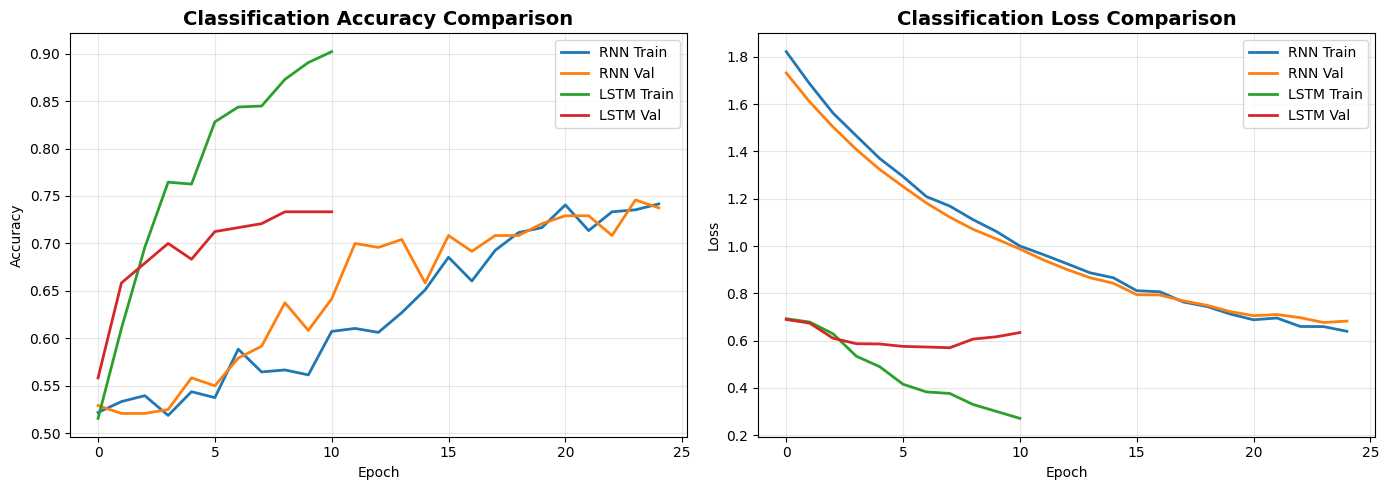

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history_rnn_cls.history['accuracy'], label='RNN Train', linewidth=2)
axes[0].plot(history_rnn_cls.history['val_accuracy'], label='RNN Val', linewidth=2)
axes[0].plot(history_lstm_cls.history['accuracy'], label='LSTM Train', linewidth=2)
axes[0].plot(history_lstm_cls.history['val_accuracy'], label='LSTM Val', linewidth=2)
axes[0].set_title('Classification Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history_rnn_cls.history['loss'], label='RNN Train', linewidth=2)
axes[1].plot(history_rnn_cls.history['val_loss'], label='RNN Val', linewidth=2)
axes[1].plot(history_lstm_cls.history['loss'], label='LSTM Train', linewidth=2)
axes[1].plot(history_lstm_cls.history['val_loss'], label='LSTM Val', linewidth=2)
axes[1].set_title('Classification Loss Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()